CS 228 Homework 3

note that the variable epochs is set to '64000' (essentially 200 epochs) which would take a lot of time to run, you can change it to 32000 for 100 epochs for batch size 32

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import RandomSampler
from torch import optim
import torch.nn as nn
# warnings.filterwarnings('ignore')

Getting full data  

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0, 0, 0), (1, 1, 1))])

trainset_full = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset_full = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = DataLoader(trainset_full, batch_size=len(trainset_full))
test_loader = DataLoader(testset_full, batch_size=len(testset_full))

train_images = next(iter(train_loader))[0].numpy()
train_labels = next(iter(train_loader))[1].numpy().reshape(-1,1)
test_images = next(iter(test_loader))[0].numpy()
test_labels = next(iter(test_loader))[1].numpy().reshape(-1,1)
print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
(50000, 3, 32, 32) (50000, 1) (10000, 3, 32, 32) (10000, 1)


In [3]:


def get_one_hot(np_labels):
    np_enc = np.zeros((np_labels.shape[0], 10), dtype='uint8')
    np_enc[np.arange(np_labels.shape[0]), np_labels] = 1
    return np_enc

def get_data():
    for i in range(10):
        idx = (train_labels == i).reshape(train_images.shape[0])
        all_f_img = train_images[idx]
        all_f_lab = train_labels[idx]
        random_indices = np.random.choice(all_f_img.shape[0], size=1000, replace=False)
        if i == 0:
            x_train = all_f_img[random_indices, :]   
            y_train = all_f_lab[random_indices, :]
        else:
            x_train = np.vstack([x_train, all_f_img[random_indices, :]])
            y_train = np.vstack([y_train, all_f_lab[random_indices, :]])
    y_train = get_one_hot(y_train.reshape(-1,))
    y_test = get_one_hot(test_labels.reshape(-1,))
    return torch.tensor(x_train), torch.tensor(y_train), torch.tensor(test_images), torch.tensor(y_test)
    

Taking 10000 trainning examples from full dataset 

In [4]:
x_train, y_train, x_test, y_test = get_data()
x_train, y_train, x_test, y_test = x_train.cuda(), y_train.cuda(), x_test.cuda(), y_test.cuda()
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

torch.Size([10000, 3, 32, 32]) torch.Size([10000, 10]) torch.Size([10000, 3, 32, 32]) torch.Size([10000, 10])


In [5]:
dataset = TensorDataset(x_train, y_train)
batch_s = 32
train_loader = DataLoader(dataset, batch_size=batch_s , sampler = RandomSampler(dataset, replacement=True, num_samples=batch_s))
epochs = 64000
t_loss_ind = np.linspace(epochs/10,epochs,200,dtype=int)

In [15]:

def plot_all(l_l):
    fig,axs = plt.subplots(1,3,figsize=(15,5))
    y_l = ["Loss","Training Accuracy","Testing Accuracy"]
    label_l = ["No augmentation", "Mixup (0.2)", "Mixup (0.4)", "Cutout", "Standard", "All combined"]
    for i in range(3):
        axs[i].set_title(y_l[i])
        axs[i].set_ylabel(y_l[i])
        axs[i].set_xlabel("Epochs")
        for j in range(6):          
          axs[i].plot(list(t_loss_ind), l_l[j][i], label = label_l[j])
    plt.legend()

def get_accuracy(f, Y):
    f = np.argmax(f, axis=1)
    Y = np.argmax(Y, axis=1)
    return np.mean(Y==f)

def mixup_aug(x, y, alpha):
    lambda_ = np.random.beta(alpha, alpha)
    n1 = np.random.randint(0, batch_s, batch_s)
    n2 = np.random.randint(0, batch_s, batch_s)
    x = (lambda_*x[n1] + (1-lambda_)*x[n2])
    y = (lambda_*y[n1] + (1-lambda_)*y[n2])
    return torch.tensor(x).cuda(), torch.tensor(y).cuda()

    
def cutout_aug(x, K):
    ids = np.where(np.random.rand(batch_s) > 0.5)[0]
    cx = np.random.randint(0, 32, len(ids))
    cy = np.random.randint(0, 32, len(ids))
    x1 = cx - K//2
    x1[x1 < 0] = 0
    x2 = cx + K//2
    x2[x2 > 32] = 32
    y1 = cy - K//2
    y1[y1 < 0] = 0
    y2 = cy + K//2
    y2[y2 > 32] = 32
    for i, img in enumerate(ids):
        x[img, :, x1[i]:x2[i], y1[i]:y2[i]] = 0
    return x

def std_aug(x, K): 

    k1 = np.random.randint(-K, K, batch_s)
    k2 = np.random.randint(-K, K, batch_s)    
    for j in range(batch_s):
        x[j] = np.roll(x[j], (k1[j], k2[j]), axis=(1, 2))
        if (k1[j]>0) and (k2[j]>0):          
            x[j, :, 0:k1[j], :] = 0
            x[j, :, :, 0:k2[j]] = 0
        elif (k1[j]>0) and (k2[j]<0):
            x[j, :, 0:k1[j], :] = 0
            x[j, :, :, k2[j]:32] = 0
        elif (k1[j]<0) and k2[j]>0:
            x[j, :, k1[j]:32, :] = 0
            x[j, :, :, 0:k2[j]] = 0
        elif (k1[j]<0) and  (k2[j]<0):
            x[j, :, k1[j]:32,:] = 0
            x[j, :, :, k2[j]:32] = 0

        hori_flip = np.random.rand(batch_s)
        if hori_flip[j] > 0.5:
            # torch.flip(x[j], [2])
            x[j,0] = np.fliplr(x[j,0])
            x[j,1] = np.fliplr(x[j,1])
            x[j,2] = np.fliplr(x[j,2])          

    return torch.tensor(x).cuda()

def resnet_model(trainloader, data_aug = 'No Augmentation', val=0):

    model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
    model.cuda()
    model.fc = nn.Linear(512, 10, device='cuda')
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_lst, train_accu_lst, test_accu_lst = [], [], []

    for i in range(epochs+1):
        for x,y in trainloader:
            optimizer.zero_grad()

            if data_aug == 'mixup':
                x, y = mixup_aug(x.cpu().detach().numpy(), y.cpu().detach().numpy(), val)
            elif data_aug == 'cutout':
                x = cutout_aug(x, val)
            elif data_aug == 'std':
                x = std_aug(x.cpu().detach().numpy(), val)
            elif data_aug == 'all_c':
                x = std_aug(x.cpu().detach().numpy(), 4)
                x = cutout_aug(x, 16)
                x, y = mixup_aug(x.cpu().detach().numpy(), y.cpu().detach().numpy(), 0.4)

            y_pred = model(x.float())
            loss = criterion(y_pred, y.float())
            if i in t_loss_ind:            
                loss_lst.append(float(loss))
                accu = get_accuracy(model(x_train.float()).cpu().detach().numpy(), y_train.cpu().detach().numpy())
                train_accu_lst.append(accu)
                accu = get_accuracy(model(x_test.float()).cpu().detach().numpy(), y_test.cpu().detach().numpy())
                test_accu_lst.append(accu)
                
            loss.backward()
            optimizer.step()
    
    print(data_aug, " Final Test Accuracy  ", sum(test_accu_lst[-5:])/5)
    return loss_lst, train_accu_lst, test_accu_lst

Function call for implementation without augmentation

In [7]:
lst_lst = []
lst_lst.append(resnet_model(train_loader))

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip


No Augmentation  Final Test Accuracy   0.6484


Function call for implementation with Mixup augmentation with alpha=0.2

In [8]:
lst_lst.append(resnet_model(train_loader, 'mixup', 0.2))

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


mixup  Final Test Accuracy   0.6712


Function call for implementation with Mixup augmentation with alpha=0.4

In [9]:
lst_lst.append(resnet_model(train_loader, 'mixup', 0.4))

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


mixup  Final Test Accuracy   0.6773


Function call for implementation with Cutout augmentation with K=16

In [10]:
lst_lst.append(resnet_model(train_loader, 'cutout', 16))

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


cutout  Final Test Accuracy   0.6674


Function call for implementation with Standard augmentation with K=4

In [11]:
lst_lst.append(resnet_model(train_loader, 'std', 4))

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


std  Final Test Accuracy   0.7635


Function call for implementation with all augmentations

In [12]:
lst_lst.append(resnet_model(train_loader, 'all_c'))
# all_loss_l[5], all_train_accu_l[5], all_test_accu_l[5] = resnet_model(train_loader, 'all_c')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


all_c  Final Test Accuracy   0.7691


Plotting all data

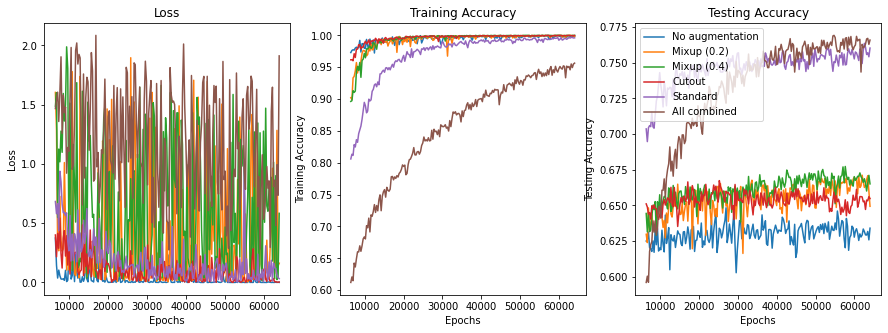

In [14]:
# print(lst_lst)
plot_all(lst_lst)